## Compound eye inspired CNN model (version 2)

In [11]:
from pathlib import Path

import numpy as np
from numba import njit

### Load data

In [12]:
img_size = 784
img_width = 28
img_shape = (28, 28)

train_data = np.loadtxt(Path('D:/Development/Python/jupyter/data/csv/mnist_train_small.csv'), delimiter=',')
test_data = np.loadtxt(Path('D:/Development/Python/jupyter/data/csv/mnist_test.csv'), delimiter=',')

n_train_samples = train_data.shape[0]
n_test_samples = test_data.shape[0]

### Generate dataset

In [13]:
def one_hot(n: int, idx: int) -> np.ndarray:
    q = np.zeros(n)
    q[idx] = 1.0
    return q

In [14]:
x_train = train_data[:,1:] / 255.0
y_train = np.array([one_hot(10, int(i)) for i in train_data[:,0]])

x_test = test_data[:,1:] / 255.0
y_test = np.array([one_hot(10, int(i)) for i in test_data[:,0]])

### Transform data to 2D shape

In [15]:
x_train_tmp = np.zeros((n_train_samples, img_width, img_width))
x_test_tmp = np.zeros((n_test_samples, img_width, img_width))

for i in range(n_train_samples):
    x_train_tmp[i] = x_train[i].reshape(img_shape)

for i in range(n_test_samples):
    x_test_tmp[i] = x_test[i].reshape(img_shape)

x_train = x_train_tmp
x_test = x_test_tmp

### Define activation functions

In [16]:
@njit(fastmath=True)
def ReLU(x: np.ndarray) -> np.ndarray:
    return np.maximum(np.zeros(x.shape), x)


@njit(fastmath=True)
def d_ReLU(x: np.ndarray) -> np.ndarray:
    return 1 * (x > 0)


@njit(fastmath=True)
def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1 / (1 + np.exp(-x))


@njit(fastmath=True)
def d_sigmoid(x: np.ndarray) -> np.ndarray:
    y = 1 / (1 + np.exp(-x))
    return y * (1 - y)


@njit(fastmath=True)
def softmax(x: np.ndarray) -> np.ndarray:
    y = np.exp(x)
    return y / np.sum(y)

### Define model

In [17]:
@njit(fastmath=True)
def conv(x: np.ndarray, V: np.ndarray, c: np.ndarray, i: int, j: int) -> float:
    z = 0

    for ii in range(V.shape[0]):
        for jj in range(V.shape[1]):
            z += V[ii][jj] * x[i+ii][j+jj]
    
    return z + c


@njit(fastmath=True)
def convolution(x: np.ndarray, V: np.ndarray, c: np.ndarray, n_features: int) -> np.ndarray:
    z = np.zeros(n_features**2)

    for i in range(n_features):
        for j in range(n_features):
            idx = n_features * i + j
            z[idx] = conv(x, V[idx], c[idx], i, j)
    
    return z


@njit(fastmath=True)
def grads(x_batch: np.ndarray, y_batch: np.ndarray, V: np.ndarray, c:np.ndarray, W: np.ndarray, b: np.ndarray, n_features: int, kernel_size: int) -> tuple[np.ndarray]:
    dV = np.zeros(V.shape)
    dc = np.zeros(c.shape)

    dW = np.zeros(W.shape)
    db = np.zeros(b.shape)

    for i in range(x_batch.shape[0]):
        u = convolution(x_batch[i], V, c, n_features)
        z = ReLU(u)
        y = softmax(W @ z + b)

        dLdy = y - y_batch[i]
        dLdu = (W.T @ dLdy) * d_ReLU(u)

        for j in range(n_features):
            for k in range(n_features):
                idx = n_features * j + k
                dV[idx] += dLdu[idx] * x_batch[i, j:j+kernel_size, k:k+kernel_size]
                dc[idx] += dLdu[idx]

        dW += np.outer(dLdy, z)
        db += dLdy

    return (dV, dc, dW, db)


class Perceptron:
    def __init__(self, img_width: int, n_features: int, n_out: int) -> None:
        self.img_width = img_width
        self.n_features = n_features
        self.kernel_size = img_width - n_features + 1
        self.n_out = n_out

        self.V: np.ndarray = np.random.uniform(-1, 1, (n_features**2, self.kernel_size, self.kernel_size))
        self.c: np.ndarray = np.zeros(n_features**2)

        self.W: np.ndarray = np.random.uniform(-1, 1, (n_out, n_features**2))
        self.b: np.ndarray = np.zeros(n_out)

    def predict(self, x: np.ndarray) -> np.ndarray:
        z = ReLU(convolution(x, self.V, self.c, self.n_features))
        return softmax(self.W @ z + self.b)

    def loss(self, x: np.ndarray, y: np.ndarray) -> float:
        ypred = np.array([self.predict(xi) for xi in x])
        h = -np.mean(y * np.log(ypred), axis=1)
        return np.mean(h)

    def train(self, x_train: np.ndarray, y_train: np.ndarray, lr, batch_size, max_epoch) -> None:
        n = x_train.shape[0]

        for epoch in range(max_epoch):
            idxs = np.random.permutation(n)
            n_batches = n // batch_size

            for i in range(n_batches):
                ibegin = i * batch_size
                iend = min((i + 1) * batch_size, n - 1)
                batch_idxs = idxs[ibegin:iend]

                dV, dc, dW, db = grads(x_train[batch_idxs], y_train[batch_idxs], self.V, self.c, self.W, self.b, self.n_features, self.kernel_size)

                self.V -= lr * dV
                self.c -= lr * dc

                self.W -= lr * dW
                self.b -= lr * db

### Create and train model

In [28]:
img_width = 28
n_features = 4
n_out = 10

learning_rate = 1e-2
batch_size = 64
max_epoch = 4

model = Perceptron(img_width, n_features, n_out)

print('untrained loss: ', model.loss(x_test, y_test).round(3))
model.train(x_train, y_train, learning_rate, batch_size, max_epoch)
print('trained loss: ', model.loss(x_test, y_test).round(3))

n_true_pos = 0

for x, y in zip(x_test, y_test):
    ypred = model.predict(x)
    n_true_pos += 1 if np.argmax(ypred) == np.argmax(y) else 0

accuracy = n_true_pos / x_test.shape[0]
print(f"test set accuracy: {round(accuracy * 100, 2)}%")

untrained loss:  1.291
trained loss:  0.044
test set accuracy: 86.86%


In [24]:
n_weights = model.V.size + model.W.size
n_biases = model.c.size + model.b.size
model_size = n_weights + n_biases

print(f'model size: {model_size}')
print(f'total weights: {n_weights}')
print(f'total biases: {n_biases}')

model size: 24265
total weights: 24206
total biases: 59


### Visualize classes mean convolution feature maps

In [25]:
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [26]:
classes_conv_features = []

for i in range(10):
    x = [xi for (xi, yi) in zip(x_train, y_train) if np.argmax(yi) == i]
    x = np.array(x)

    z = np.array([ReLU(convolution(xi, model.V, model.c, n_features)) for xi in x])
    z = np.mean(z, axis=0)

    classes_conv_features.append(z)

classes_conv_features = np.array(classes_conv_features)

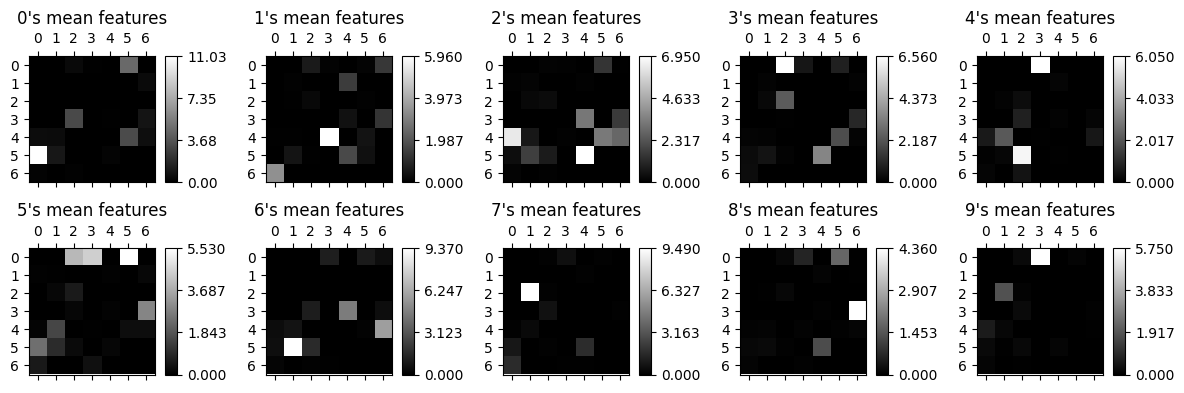

In [27]:
fig, axes = plt.subplots(nrows=2, ncols=5)
fig.set_dpi(100)
fig.set_figwidth(12)
fig.set_figheight(4)

for i, ax in enumerate(axes.ravel()):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="10%", pad=0.1)

    z = classes_conv_features[i]
    img = ax.matshow(z.reshape((n_features, n_features)), cmap='binary_r')

    cbar = fig.colorbar(img, ax=ax, cax=cax)
    cmin = round(np.min(z), 2)
    cmax = round(np.max(z), 2)
    cbar.set_ticks(np.linspace(cmin, cmax, 4))

    ax.set_title(f'{i}\'s mean features')

plt.tight_layout()
plt.show()